# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

/Users/olegchernikov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# !wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [3]:
df = pd.read_csv('yearpredictionmsd.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [4]:
# df = pd.read_csv('data.txt.zip', header=None)
# df.head()

Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
X_train_scaled

array([[ 1.07878578,  0.3915658 ,  1.82696245, ..., -0.47047696,
        -0.25536649,  0.04263679],
       [ 0.87951065,  0.33263074,  1.74896068, ...,  0.57086074,
         0.20934068,  1.16111783],
       [ 1.24551515,  0.59277085,  1.33754998, ..., -0.33808131,
         0.10782848, -0.09012209],
       ...,
       [ 0.16295616,  0.00705667,  0.83696599, ..., -0.66394994,
         0.01455343, -0.24641243],
       [ 0.2470323 ,  0.24967363, -0.40712469, ...,  0.53492495,
         0.46999692,  0.7024367 ],
       [ 1.14103808,  0.10560857,  1.28757254, ..., -0.05011829,
        -0.33914232, -0.05763319]])

In [8]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [9]:
set_random_seed(42)

In [10]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [11]:
model = Ridge()
ridged = model.fit(X_train_scaled, y_train)
y_pred = ridged.predict(X_test_scaled)
rmse_for_model = np.sqrt(mean_squared_error(y_test, y_pred))

In [12]:
rmse_for_model

9.510160820470437

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [13]:
best_rmse_metric = np.sqrt(np.sum((y_train.mean() - y_test)**2))
best_rmse_metric

2465.9224392300707

In [14]:
X_train.shape

(463715, 90)

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [15]:
w = torch.rand(90, requires_grad=True)
a = torch.rand(1, requires_grad=True)

X_train_scaled_tensor = torch.tensor(X_train_scaled)
X_test_scaled_tensor = torch.tensor(X_test_scaled)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)


In [16]:
losses = {}

In [17]:
epochs = 10

for epoch in range(epochs):
    y_pred = torch.sum(w * X_train_scaled_tensor, dim=1) + a
    loss = torch.sqrt(torch.mean((y_pred - y_train_tensor) ** 2))
    loss.backward()
    

    w.data -= 0.05 * w.grad
    a.data -= 0.05 * a.grad

    w.grad.data.zero_()
    a.grad.data.zero_()
    
    y_pred_test = torch.sum(w * X_test_scaled_tensor, dim=1) + a
    error = torch.sqrt(torch.mean((y_pred_test - y_test_tensor) ** 2))
    
    losses[epoch] = list([float(loss), float(error)])

In [18]:
results = pd.DataFrame(losses).T
results = results.rename(columns={0:'Loss train', 1:'Loss test'})
results

,Loss train,Loss test
0,1997.826707,1997.833806
1,1997.776705,1997.783826
2,1997.726702,1997.733847
3,1997.676700,1997.683868
4,1997.626698,1997.633888
5,1997.576696,1997.583909
6,1997.526693,1997.533929
7,1997.476691,1997.483950
8,1997.426689,1997.433970
9,1997.376686,1997.383991


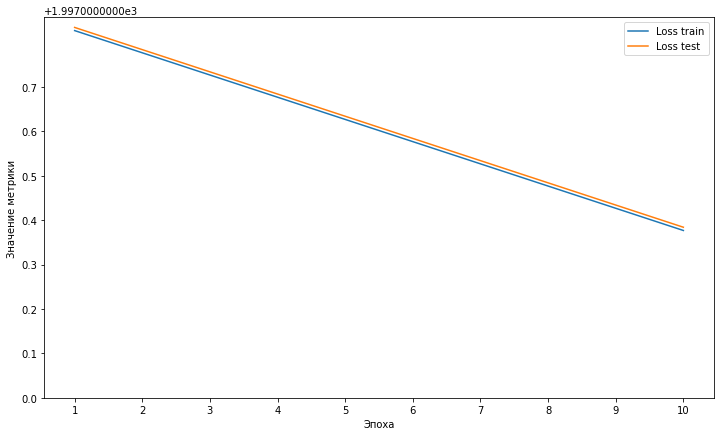

In [19]:
plt.figure(figsize=(12, 7))
sns.lineplot(y=results['Loss train'], x=np.arange(1, 11))
sns.lineplot(y=results['Loss test'], x=np.arange(1, 11))
plt.xticks(np.arange(1, 11))
plt.yticks(np.arange(1997, 1997.7, 0.10))
plt.xlabel('Эпоха')
plt.ylabel('Значение метрики')
plt.legend(labels=['Loss train', 'Loss test']);

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [20]:
from sklearn.preprocessing import StandardScaler

# Нормируем таргет:

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

In [21]:
# Задаем гиперпараметры и делаем из numpy tensor:

n_samples, n_features = X_train_scaled_tensor.shape
n_epochs = 5
learning_rate = 0.01
X_train_tensor = torch.from_numpy(X_train_scaled)
X_train_tensor = X_train_tensor.type(torch.float)
X_test_tensor = torch.from_numpy(X_test_scaled)
X_test_tensor = X_test_tensor.type(torch.float)
y_train_tensor = torch.from_numpy(y_train_scaled)
y_train_tensor = y_train_tensor.type(torch.float)
y_test_tensor = torch.from_numpy(y_test_scaled)
y_test_tensor = y_test_tensor.type(torch.float)

In [22]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return {
            "sample": torch.tensor(self.x[idx, :], dtype=torch.float),
            "target": self.y[idx],
        }

In [23]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.lin2 = nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x):
        self.lin1(x)
        self.relu1(x)
        self.dropout1(x)
        return self.lin2(x)

In [24]:
train_set = Dataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=100
)

test_set = Dataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=100
)

model = Model(n_features, n_features, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [25]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    for epoch in range(n_epochs):
        iteration = 0
        for batch in train_loader:
            y_pred = model(batch['sample'])
            
            loss = criterion(batch['target'], y_pred)
            
            loss.backward()
            
            optimizer.step()
            
            optimizer.zero_grad()
            
            if iteration % 100 == 0:
                print('epoch: ', epoch+1, ', iter: ', iteration, ', loss: ', loss.item())
                iteration += 1
            else:
                iteration += 1
        
#     raise NotImplementedError


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    
    predicts = torch.ones(len(test_loader.dataset))
    ind = 0
    total_loss = 0 # суммарная ошибка на каждом батче
    for batch in test_loader:
        y_pred = model(batch['sample'])
        
        loss = criterion(batch['target'], y_pred) # ошибка на батче
        
        total_loss += loss
        
        for val in y_pred:
            predicts[ind] = val
            ind += 1
    return predicts, total_loss/len(test_loader) # возвращаем нормированную по количеству батчей суммарную ошибку


In [26]:
# assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

In [27]:
train(model, optimizer, criterion, train_loader, test_loader)

/var/folders/7c/f8xjv4ln3gscgmy55z3877_40000gn/T/ipykernel_57639/3884859171.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "sample": torch.tensor(self.x[idx, :], dtype=torch.float),


epoch:  1 , iter:  0 , loss:  0.5794607400894165
epoch:  1 , iter:  100 , loss:  0.8760538697242737
epoch:  1 , iter:  200 , loss:  0.5398319959640503
epoch:  1 , iter:  300 , loss:  0.15332984924316406
epoch:  1 , iter:  400 , loss:  0.4772321283817291
epoch:  1 , iter:  500 , loss:  0.23164114356040955
epoch:  1 , iter:  600 , loss:  0.3739667236804962
epoch:  1 , iter:  700 , loss:  0.304289847612381
epoch:  1 , iter:  800 , loss:  0.7455514669418335
epoch:  1 , iter:  900 , loss:  0.8750280141830444
epoch:  1 , iter:  1000 , loss:  0.45143187046051025
epoch:  1 , iter:  1100 , loss:  1.1212584972381592
epoch:  1 , iter:  1200 , loss:  1.411228060722351
epoch:  1 , iter:  1300 , loss:  0.30353498458862305
epoch:  1 , iter:  1400 , loss:  1.2376726865768433
epoch:  1 , iter:  1500 , loss:  0.36926570534706116
epoch:  1 , iter:  1600 , loss:  0.10703416913747787
epoch:  1 , iter:  1700 , loss:  0.2730071246623993
epoch:  1 , iter:  1800 , loss:  0.5050711631774902
epoch:  1 , iter:  1

epoch:  4 , iter:  1700 , loss:  0.27479320764541626
epoch:  4 , iter:  1800 , loss:  0.5045387148857117
epoch:  4 , iter:  1900 , loss:  1.7793464660644531
epoch:  4 , iter:  2000 , loss:  4.328573703765869
epoch:  4 , iter:  2100 , loss:  0.5593375563621521
epoch:  4 , iter:  2200 , loss:  0.3670630156993866
epoch:  4 , iter:  2300 , loss:  1.0248500108718872
epoch:  4 , iter:  2400 , loss:  1.973364233970642
epoch:  4 , iter:  2500 , loss:  0.40747928619384766
epoch:  4 , iter:  2600 , loss:  0.6588828563690186
epoch:  4 , iter:  2700 , loss:  0.3949040174484253
epoch:  4 , iter:  2800 , loss:  0.3516010642051697
epoch:  4 , iter:  2900 , loss:  1.9176201820373535
epoch:  4 , iter:  3000 , loss:  0.2595658600330353
epoch:  4 , iter:  3100 , loss:  0.8120089173316956
epoch:  4 , iter:  3200 , loss:  0.2903681695461273
epoch:  4 , iter:  3300 , loss:  0.3351898491382599
epoch:  4 , iter:  3400 , loss:  0.22249235212802887
epoch:  4 , iter:  3500 , loss:  0.2678089439868927
epoch:  4 ,

In [28]:
y_pred, total_loss= test(model, criterion, test_loader)
y_pred # предикты для тестовой выборки

/var/folders/7c/f8xjv4ln3gscgmy55z3877_40000gn/T/ipykernel_57639/3884859171.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "sample": torch.tensor(self.x[idx, :], dtype=torch.float),


tensor([-0.1755,  0.5293,  0.3610,  ..., -0.0115,  0.4792,  0.3500],
       grad_fn=<CopySlices>)

In [30]:
Y_reversed = scaler.inverse_transform(y_test_scaled)
Y_reversed

array([[2007.],
       [2003.],
       [2005.],
       ...,
       [2006.],
       [2006.],
       [2005.]])

In [47]:
# Y = torch.from_numpy(Y_reversed.reshape(51630,))
# Y # приведенный в удобный для подсчета вид таргет

In [38]:
y_pred_reversed = scaler.inverse_transform(y_pred.detach().numpy().reshape(-1, 1))
y_pred_reversed

array([[1996.466 ],
       [2004.1769],
       [2002.3354],
       ...,
       [1998.26  ],
       [2003.628 ],
       [2002.2148]], dtype=float32)

In [45]:
np.sqrt(np.mean((y_pred_reversed - Y_reversed)**2))

9.819194388054553

In [46]:
# print(f'RMSE, посчитанное criterion на всей выборке: {torch.sqrt(criterion(y_pred_reversed, Y)).item()}')
# print(f'RMSE, посчитанное руками на всей выборке: {(((y_pred_reversed - Y)**2).mean()).sqrt().item()}')
# print(f'RMSE, посчитанное как среднее из criterion для каждого батча: {total_loss.sqrt().item() }')

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

**Отчет**: Изначально, я написал модель (class Model) с 1 линейным преобразованием (nn.Linear), причем я не нормировал таргет и остальные данные. Модель мгновенно начинала переобучаться, да так, что на выходе были просто nan, потому что в какой-то момент значения весов достигали бесконечности (выводилось это, как inf). Я пытался менять архетикртуру модели, делал несколько линейных слоев, добавлял регуляризацию в виде Dropout с разными вероятностями (даже 0.9 в надежде, что это остановит переобучение), менял шаг градиентного спуска, увеличивал и уменьшал количество батчей, но ничего не помогала. После 3-4 батча, веса улетали в бесконечность. После этого я все-таки отнормировал весь массив данных, то есть таргет и все признаки. Сделав это, качество модели сразу же улучшилось (как минимум, на выходе больше не было nan). По сути, это был самый важный шаг. Касательно архетиктуры модели, я остановился на двух линейных слоях (Linear), после первого добавив нелинейность в виде ReLU и регуляризацию Dropout с вероятностью выброса нейрона 0.5 (т.к. на семинаре говорилось о том, что это оптимальное значение и особо экспериментировать с ним нет смысла), чтобы модель не переобучалась. Я также пробовал добавлять nn.BatchNorm1d после первого линейного слоя, но, поскольку данные уже были отнормированы, это не имело особого смысла и на качество модели почти никак не повлияло. Размер батча выбрал 100, так как это не слишком много и не очень мало, чтобы модель не так долго обучалась. Пробовал еще 2 разных шага для градиента: 0.01 и 0.05. Выяснилось, что при меньшем шаге качество модели лучше, поэтому остановился на 0.01.  